In [47]:
# from https://chrishavlin.com/2019/08/20/shapefiles-in-python-converting-contours-to-shapes/

'''
countourf_to_shp.py

an example for converting the results of a matplotlib contourf plot to a
shapefile, preserving contour level data

to run:

python contourf_to_shp

outputs data in data/shaped_contour, plots a figure

Copyright (C) 2019  Chris Havlin, <https://chrishavlin.wordpress.com>
    This program is free software: you can redistribute it and/or modify
    it under the terms of the GNU General Public License as published by
    the Free Software Foundation, either version 3 of the License, or
    (at your option) any later version.
    This program is distributed in the hope that it will be useful,
    but WITHOUT ANY WARRANTY; without even the implied warranty of
    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    GNU General Public License for more details.
    You should have received a copy of the GNU General Public License
    along with this program.  If not, see <http://www.gnu.org/licenses/>.

'''

'\ncountourf_to_shp.py\n\nan example for converting the results of a matplotlib contourf plot to a\nshapefile, preserving contour level data\n\nto run:\n\npython contourf_to_shp\n\noutputs data in data/shaped_contour, plots a figure\n\nCopyright (C) 2019  Chris Havlin, <https://chrishavlin.wordpress.com>\n    This program is free software: you can redistribute it and/or modify\n    it under the terms of the GNU General Public License as published by\n    the Free Software Foundation, either version 3 of the License, or\n    (at your option) any later version.\n    This program is distributed in the hope that it will be useful,\n    but WITHOUT ANY WARRANTY; without even the implied warranty of\n    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the\n    GNU General Public License for more details.\n    You should have received a copy of the GNU General Public License\n    along with this program.  If not, see <http://www.gnu.org/licenses/>.\n\n'

In [20]:
from shapely import geometry
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import fiona
import os,json
from descartes.patch import PolygonPatch

from glob import glob
import xarray as xr
import dask.array as da

In [6]:
# create some test data with multiple peaks
lon = np.linspace(0,45,100)
lat = np.linspace(-20,32,90)
long,latg=np.meshgrid(lon,lat)
C1=np.sqrt((long-5.)**2+(latg-25)**2)/30.
C2=np.sqrt((long-30.)**2+(latg-1)**2)/10.
m = 30*np.exp(-C1**2)+20.*np.exp(-C2**2)

In [34]:
!ls

Coast_tagging_makePWhistogram.ipynb
Coast_tagging_old.ipynb
Extract_WEIO_from_MERRA2.ipynb
LICENSE
MERRA2_400.inst1_2d_asm_Nx.20140515.SUB.nc
README.md
TQV_Contours_shapefiles.ipynb
Track_Lakes_Backward.ipynb
Track_Lakes_Backward_earliest_version.ipynb
Whiteboard[2].pdf
contourf_to_shp.py
landmask_MERRA2.nc
test_shaped_contour


In [38]:
files = glob('MERRA2*.nc') #+glob('*2015*')+glob('*2016*')+glob('*2017*')+glob('*2018*') # selecting 2014-2018
cwv_data = xr.open_mfdataset(files) # merging data files in one

lon = cwv_data.lon
lat = cwv_data.lat
m = cwv_data.TQV[0].values
m

array([[18.001326, 18.907576, 19.806013, ..., 15.485701, 16.337263,
        17.20445 ],
       [19.64195 , 20.126326, 20.32945 , ..., 17.51695 , 18.1732  ,
        18.899763],
       [20.727888, 21.509138, 22.970076, ..., 18.970076, 19.3607  ,
        19.962263],
       ...,
       [20.095076, 22.220076, 24.009138, ..., 18.45445 , 18.64195 ,
        19.251326],
       [18.51695 , 19.9857  , 22.384138, ..., 19.946638, 18.962263,
        18.3607  ],
       [18.181013, 18.313826, 20.087263, ..., 21.407576, 20.618513,
        19.384138]], dtype=float32)

<Figure size 720x360 with 0 Axes>

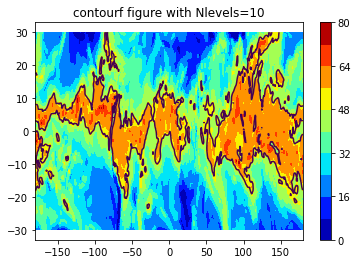

In [18]:
# make the contourf plot, storing the resulting ContourSet in cs
plt.figure(figsize=[10,5])
fig, ax = plt.subplots()

Nlevels=10
cs = plt.contourf(lon,lat,m,Nlevels,cmap='jet')
ax.contour(lon,lat,m,[50])
plt.title('contourf figure with Nlevels='+str(Nlevels))
plt.colorbar()
ax.set_xlim([-180,180])
ax.set_ylim([-33,33])


# create lookup table for levels
lvl_lookup = dict(zip(cs.collections, cs.levels))

# loop over collections (and polygons in each collection), store in list for fiona
PolyList=[]
for col in cs.collections:
    z=lvl_lookup[col] # the value of this level
    for contour_path in col.get_paths():
        # create the polygon for this level
        for ncp,cp in enumerate(contour_path.to_polygons()):
            lons = cp[:,0]
            lats = cp[:,1]
            new_shape = geometry.Polygon([(i[0], i[1]) for i in zip(lons,lats)])            
            if ncp == 0:
                poly = new_shape # first shape
            else:
                poly = poly.difference(new_shape) # Remove the holes
        PolyList.append({'poly':poly,'props':{'z': z}})

## write the fiona collection

# clean up directories
outname=os.path.join('.','test_shaped_contour')
if os.path.isdir(outname):
    for file in os.listdir(outname):
        os.remove(os.path.join(outname,file))
    os.rmdir(outname)
os.mkdir(outname)

# define ESRI schema, write each polygon to the file
outfi=os.path.join(outname,'shaped_contour.shp')
schema = {'geometry': 'Polygon','properties': {'z': 'float'}}
with fiona.collection(outfi, "w", "ESRI Shapefile", schema) as output:
    for p in PolyList:
        output.write({'properties': p['props'],
            'geometry': geometry.mapping(p['poly'])})

# save the levels and global min/max as a separate json for convenience
Lvls={'levels':cs.levels.tolist(),'min':m.min(),'max':m.max()}

In [40]:
Lvls

{'levels': [0.0, 8.0, 16.0, 24.0, 32.0, 40.0, 48.0, 56.0, 64.0, 72.0, 80.0],
 'min': 0.7347245,
 'max': 74.948685}

In [42]:
#with open(os.path.join(outname,'levels.json'), 'w') as fp:
#    json.dump(Lvls, fp) # min,max are floats, which are not JSON writable - must be strings

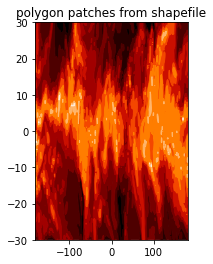

In [45]:
## Plotting the results: reads data back in, plots the polygons with data only
## from shapefile and levels.txt

ax=plt.subplot(1,2,2)

# read in levels, define colormap
#with open(os.path.join(outname,'levels.json')) as jfile:
#    Lvls=json.load(jfile) # min,max are floats, which are not JSON writable - must be strings
levels=np.array(Lvls['levels'])
cmap=plt.cm.gist_heat
lv_range=[Lvls['min'],Lvls['max']]

# loop over each shape, pull out level value ('z'), plot a polygon with a color
# matching the colormap.
ishp=0
with fiona.open(outfi) as shape:
    for shp in shape:

        # pull this shape's level and set the color from the map
        lv=shp['properties']['z'] # this shape's level
        clr=cmap((lv - lv_range[0])/(lv_range[1]-lv_range[0]))

        # build the polygon and add the patch
        coords=shp['geometry']['coordinates'][0] # coords of this polygon
        poly=geometry.Polygon(coords)
        patch = PolygonPatch(poly, facecolor=clr, edgecolor=clr)
        ax.add_patch(patch)

        # track max/min coordinate values
        bnds=poly.bounds
        rng_C={'lon':{'min':bnds[0],'max':bnds[2]},
               'lat':{'min':bnds[1],'max':bnds[3]}}
        if ishp==0:
            rngs=rng_C
        else:
            for ll in ['lon','lat']:
                rngs[ll]['max']=max([rngs[ll]['max'],rng_C[ll]['max']])
                rngs[ll]['min']=min([rngs[ll]['min'],rng_C[ll]['min']])
        ishp=ishp+1

ax.set_xlim([rngs['lon']['min'],rngs['lon']['max']])
ax.set_ylim([rngs['lat']['min'],rngs['lat']['max']])
plt.title('polygon patches from shapefile')
plt.show()